<a href="https://colab.research.google.com/github/gladcolor/SVM_DNN_testing/blob/master/CSCE822_HW2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification using SVM

## Import packages

In [2]:
import pandas as pd

import numpy as np
import os

from sklearn.impute import SimpleImputer
# import category_encoders as ce
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

In [3]:
cwd = r'/content/drive/MyDrive/USC_courses/CSCE822'
if not os.path.exists(cwd):
    os.makedirs(cwd)
% cd $cwd

/content/drive/MyDrive/USC_courses/CSCE822


## Define functions

In [4]:
def print_str_unique(df):
    for col in df.columns:
        if original_data.dtypes[col] == np.object:            
            unique_cnt = len(df[col].unique())
            print(f'Column {col.rjust(13)} has {unique_cnt:5} unique values.')

def count_column_nan(df):
    row_cnt = len(df)
    for col in df.columns:
        nan_cnt = df[col].isna().sum()
        percent_str = f'({(nan_cnt / row_cnt * 100):3.1f}%)'.rjust(7)
        print(f'Column {str(col).rjust(13)} has {nan_cnt:4} {percent_str} nan values.')       

def impute_df(df, strategy="most_frequent"):
    
    numeric_cols = ['BuildingArea', 'YearBuilt', 'Car']
    nominal_cols = ['CouncilArea']

    my_imputer = SimpleImputer(strategy="most_frequent")
    council_area_with_imputed_values = my_imputer.fit_transform(df[nominal_cols])
    imputed_df = df.copy()
    imputed_df.loc[:, nominal_cols] = council_area_with_imputed_values


    if strategy == "most_frequent":
        my_imputer = SimpleImputer(strategy="most_frequent")
        data_with_imputed_values = my_imputer.fit_transform(df)        
        imputed_df.loc[:, :] = data_with_imputed_values

    if strategy == "mean":
        my_imputer = SimpleImputer(strategy="mean")
        area_year_with_imputed_values = my_imputer.fit_transform(df[numeric_cols])
        imputed_df.loc[:, numeric_cols] = area_year_with_imputed_values

    if strategy == "median":
        my_imputer = SimpleImputer(strategy="median")
        area_year_with_imputed_values = my_imputer.fit_transform(df[numeric_cols])
        imputed_df.loc[:, numeric_cols] = area_year_with_imputed_values

    return imputed_df

def encode_dates(imputed_df):
    imputed_df['Date'] = pd.to_datetime(imputed_df['Date']) 
    imputed_df['Ori_Date'] = pd.to_datetime('1970-01-01', format='YY-m-d', errors='ignore')
    imputed_df['Ori_Date'] = pd.to_datetime(imputed_df['Ori_Date'])
    imputed_df['delta_days'] = imputed_df['Date'] - imputed_df['Ori_Date']
    imputed_df['delta_days'] = imputed_df['delta_days'].dt.days
    imputed_df = imputed_df.drop(columns=['Date', 'Ori_Date'])
     
    return imputed_df



def encoder_nominals(imputed_df, encode_method='one_hot'):
    # print(f'Encode methods: {ENCODING_METHODS_DICT.keys()} \n')
    
    ce_encoder = ENCODING_METHODS_DICT[encode_method](cols = ENCODING_COLUMNS)

    y = imputed_df['Price_class'].copy()
    
    for drop_column in DROPPED_COLUMNS:
        try:
            imputed_df = imputed_df.drop(columns=drop_column).copy()
        except:
            pass
            # print(f'Columns: {drop_column} have already dropped before.')

    encoded_df = ce_encoder.fit_transform(imputed_df, y=y) 

    return encoded_df

def assign_price_class(imputed_df):
    row_cnt = len(imputed_df)
    price_class_cnt = 5
    class_step = int(row_cnt / price_class_cnt)
    price_bins = list(range(class_step, row_cnt,  class_step))

    imputed_df.loc[0:price_bins[0], 'Price_class'] = '0' # 'bottom_value'
    imputed_df.loc[price_bins[0]:price_bins[1], 'Price_class'] = '1' # 'low_value'
    imputed_df.loc[price_bins[1]:price_bins[2], 'Price_class'] = '2' # 'medium_value'
    imputed_df.loc[price_bins[2]:price_bins[3], 'Price_class'] = '3' # 'high_value'
    imputed_df.loc[price_bins[3]:row_cnt, 'Price_class'] = '4'  #  'top_value'

    imputed_df['Price_class'] = imputed_df['Price_class'].astype(int)

    # gb = imputed_df.groupby('Price_class')['Price_class'].count().to_frame()
    # gb.columns = ['Count']
    # custom_dict = {'bottom_value': 0, 'low_value': 1, 'medium_value': 2, 'high_value': 3, 'top_value': 4}
    # gb.sort_index(key=lambda x: x.map(custom_dict))
    # print("Price class counts:")
    return imputed_df    


def split_data(encoded_df):
    X = encoded_df.drop(columns=['Price_class'])
    y = encoded_df['Price_class']

    train_ratio = 0.75
    validation_ratio = 0.10
    test_ratio = 0.15

    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size= (1 - train_ratio), random_state = 0)

    xVal, xTest, yVal, yTest = train_test_split(xTest, yTest, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0) 

    
    return xTrain, yTrain, xVal, yVal, xTest, yTest   

def standardize_data(encoded_df, class_col='Price_class'):
    labels = encoded_df[class_col].copy()
    data_df = encoded_df.drop(columns=[class_col])
    scaler = preprocessing.StandardScaler()
    scaler.fit(data_df) 
    data_df.iloc[:, :] = scaler.transform(data_df)
    data_df.loc[:, class_col] = labels
    return data_df
           




## Load and understand the data

In [25]:
test_csv = r'https://github.com/gladcolor/SVM_DNN_testing/raw/master/test10000.zip'
test_label_csv = r'https://github.com/gladcolor/SVM_DNN_testing/raw/master/test10000_label.zip'
train_csv = r'https://github.com/gladcolor/SVM_DNN_testing/raw/master/train10000.zip'
train_label_csv = r'https://github.com/gladcolor/SVM_DNN_testing/raw/master/train10000_Label.zip'

train_df = pd.read_csv(train_csv, header=None)
train_label_df = pd.read_csv(train_label_csv, header=None)
test_df = pd.read_csv(test_csv, header=None)
test_label_df = pd.read_csv(test_label_csv, header=None)

print("Training sets samples:")
train_df.sample(4)


Training sets samples:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333
939,1.0,40,1.0,40,197000.0,1.0,3.0,999000.0,7.0,1.0,91,1,999000.0,1,0.0,170,419,447,315,7,911,350,854,310,2114,5,62,6006.0,0.0,31,23,1696,15,4,5,20,14,1980,1978,332,...,90,87,19,11,53,8,3,14,13,8,7,83,64,20,5,66,10,50,0,0,0,1,4,2,1,3,8,42,4,80,51,8,85,20,3,3,30,18,346,132
6532,999000.0,46,1.0,46,196000.0,999000.0,999000.0,8.0,5.0,999000.0,48,1,999000.0,96,999000.0,170,458,481,381,7,871,310,745,250,2463,5,54,705.0,4.0,27,36,2380,17,6,6,21,12,1965,1965,389,...,91,89,47,12,57,7,6,23,17,8,4,55,47,7,4,65,8,53,0,3,0,0,4,1,0,2,4,29,3,71,45,15,76,11,7,2,39,23,290,205
3792,999000.0,46,999000.0,46,196000.0,999000.0,999000.0,999000.0,999000.0,999000.0,50,2,999000.0,11,999000.0,170,410,442,301,6,513,330,509,300,1216,5,54,2078.0,5.0,36,32,1128,11,3,5,16,10,1965,1968,308,...,78,74,49,7,49,5,7,24,15,36,23,66,47,4,8,75,13,27,0,6,0,1,19,0,0,8,30,24,18,11,7,2,12,2,5,2,12,7,169,117
3687,999000.0,46,1.0,46,196000.0,2.0,999000.0,999000.0,7.0,999000.0,51,2,999000.0,21,999000.0,170,483,512,393,7,746,290,651,250,1857,4,62,2318.0,8.0,25,14,1522,11,3,4,20,14,1988,1986,408,...,84,65,28,12,45,8,5,20,12,16,8,77,63,2,4,57,7,49,0,1,0,1,1,0,0,6,13,34,5,80,48,18,83,14,7,4,58,18,339,149


In [ ]:
print("County nan data:")

print(f"Train data have {train_df.isna().sum().sum()} nan values.")
print(f"Test data have {test_df.isna().sum().sum()} nan values.")

train_1 = train_df[train_label_df[0] == 1]
train_0 = train_df[train_label_df[0] == 0]

def sample_train_dataset(positive_count=len(train_1), negative_count=len(train_1)):
    positive_count = len(train_1)
    negative_count = len(train_1)

    balanced_train = np.concatenate((train_1.sample(positive_count, replace=True), train_0.sample(negative_count, replace=True)), axis=0)
    balanced_train_label = np.concatenate(([1] * positive_count, [0] * negative_count), axis=0)

    print(f"Positive sample counts in the training set: {positive_count}")
    print(f"Negative sample counts in the training set: {negative_count}")

    return balanced_train, balanced_train_label


print()

print(f"Positive sample counts: {len(train_1)}")
print(f"Negative sample counts: {len(train_0)}")

County nan data:


NameError: ignored

## Train 10 SVM models in an ensemble learning manner



### Train 10 models witouth cross validation

In [ ]:
# train 10 models
from sklearn.model_selection import cross_val_score

MODEL_CNT = int(len(train_0)/len(train_1))
sample_cnt_per_portion = int(len(train_0)/MODEL_CNT)

positive_count = len(train_1)
negative_count = len(train_1)

print("Model count: ", MODEL_CNT)
print("sample_cnt_per_portion:", sample_cnt_per_portion)
trained_model_list = []

score_roc_auc_list = []
score_precision_list = []
score_recall_list = []

for i in range(MODEL_CNT):
    print(f"Training # {i + 1} model...")
    start_row = i * sample_cnt_per_portion
    end_row = start_row + sample_cnt_per_portion
    # print(start_row, end_row)

     # create a balancd training set
    train_1 = train_df[train_label_df[0] == 1].sample(frac=1)  # shuffle

    balanced_train = np.concatenate((train_1, train_0[start_row:end_row]), axis=0)
    balanced_train_label = np.concatenate(([1] * positive_count, [0] * negative_count), axis=0)

    # Use SVM
    # clf = make_pipeline(StandardScaler(), SVC(gamma='auto',
    #                                           kernel='rbf',
    #                                           verbose=True, probability=True))
    
    # Use random forest
    clf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))

    clf.fit(balanced_train, balanced_train_label)

    trained_model_list.append(clf)


Model count:  10
sample_cnt_per_portion: 909
Training # 1 model...
Training # 2 model...
Training # 3 model...
Training # 4 model...
Training # 5 model...
Training # 6 model...
Training # 7 model...
Training # 8 model...
Training # 9 model...
Training # 10 model...


### Evaluate the trained 10 models

In [ ]:
print("Evaluating...")
test_pred_list = []
for idx, clf in enumerate(trained_model_list):
    print(f"Testing # {idx + 1} model...")
    test_pred = clf.predict_proba(test_df)
    test_pred_list.append(test_pred)


Evaluating...
Testing # 1 model...
Testing # 2 model...
Testing # 3 model...
Testing # 4 model...
Testing # 5 model...
Testing # 6 model...
Testing # 7 model...
Testing # 8 model...
Testing # 9 model...
Testing # 10 model...


### Print out assessment

In [ ]:
test_pred_all = np.array(test_pred_list)

pred_label = np.where(test_pred_all[:, :, 1].mean(axis=0)>0.5, 1, 0).astype(int)

precision_score = metrics.precision_score(np.array(test_label_df), pred_label, average='macro')
precision_score = metrics.precision_score(np.array(test_label_df), pred_label, average='macro')

recall_score = metrics.recall_score(np.array(test_label_df), pred_label, average='macro')
mcc_score = metrics.matthews_corrcoef(np.array(test_label_df), pred_label)
roc_auc_score = metrics.roc_auc_score(test_label_df, test_pred_all[:, :, 1].mean(axis=0), average=None)

print("precision_score:", precision_score)
print("recall_score:", recall_score)
print("mcc_score:", mcc_score)
print("roc_auc_score:", roc_auc_score)

precision_score: 0.5383174018953414
recall_score: 0.6096338049093124
mcc_score: 0.12962843151138675
roc_auc_score: 0.6366664750885578


### Save the predicted label

In [ ]:
pred_label = np.where(test_pred_all[:, :, 1].mean(axis=0)>0.5, 1, 0).astype(int)
np.savetxt('predict.csv', pred_label, fmt='%d' )

## Train 10 models with cross validation (validating scores: precision, recall, and ROC area)
Will take about 30 min to train 300 models.

In [ ]:
# train 10 models
from sklearn.model_selection import cross_val_score

MODEL_CNT = int(len(train_0)/len(train_1))
sample_cnt_per_portion = int(len(train_0)/MODEL_CNT)

positive_count = len(train_1)
negative_count = len(train_1)

print("Model count: ", MODEL_CNT)
print("sample_cnt_per_portion:", sample_cnt_per_portion)

trained_model_list = []
scores_precision_list = []
scores_recall_list = []
scores_roc_auc_list =[]
scores_mcc_list = []
score_accuracy_list = []

USE_CROSS_VALIDATION = True   # 

def simple_matthews_corrcoef(true_np, predict_np):
    cm = metrics.confusion_matrix(true_np, predict_np)
    assert(cm.shape == (2, 2)), 'Support binary classification (2-class) only!'
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    MCC = (TP * TN - FP * FN) / (np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))

    return MCC

for i in range(MODEL_CNT):
    print(f"Training # {i + 1} model...")
    start_row = i * sample_cnt_per_portion
    end_row = start_row + sample_cnt_per_portion
    # print(start_row, end_row)

    # create a balancd training set
    balanced_train = np.concatenate((train_1, train_0[start_row:end_row]), axis=0)
    balanced_train_label = np.concatenate(([1] * positive_count, [0] * negative_count), axis=0)
    
    

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto',
                                              kernel='rbf',
                                              verbose=True, probability=True))


    # # calcuate precision, recall, AUC. actually train the model 300 times.
    score_recall = cross_val_score(clf, balanced_train, balanced_train_label, cv=10, scoring='recall')
    score_precision = cross_val_score(clf, balanced_train, balanced_train_label, cv=10, scoring='precision')
    score_roc_auc = cross_val_score(clf, balanced_train, balanced_train_label, cv=10, scoring='roc_auc')


    print("\n%0.2f precision with a standard deviation of %0.2f" % (score_precision.mean(), score_precision.std()))
    print("\n%0.2f recall with a standard deviation of %0.2f" % (score_recall.mean(), score_recall.std()))
    print("\n%0.2f AUC with a standard deviation of %0.2f" % (score_roc_auc.mean(), score_roc_auc.std()))

    trained_model_list.append(clf)
    scores_list.append(scores)

    scores_precision_list.append(score_precision)
    scores_recall_list.append(score_recall)
    # scores_roc_auc_list.append(score_roc_auc)

    # To calculate MCC only, actally train 100 models.
    # score_accuracy = cross_validate(clf, balanced_train, balanced_train_label, cv=10, return_estimator=True)
    # score_accuracy_list.append(score_accuracy)



Model count:  10
sample_cnt_per_portion: 909
Training # 1 model...
[LibSVM][LibSVM][LibSVM]Training # 2 model...
[LibSVM][LibSVM][LibSVM]Training # 3 model...
[LibSVM][LibSVM][LibSVM]Training # 4 model...
[LibSVM][LibSVM][LibSVM]Training # 5 model...
[LibSVM][LibSVM][LibSVM]Training # 6 model...
[LibSVM][LibSVM][LibSVM]Training # 7 model...
[LibSVM][LibSVM][LibSVM]Training # 8 model...
[LibSVM][LibSVM][LibSVM]Training # 9 model...
[LibSVM][LibSVM][LibSVM]Training # 10 model...
[LibSVM][LibSVM][LibSVM]

## Train 10 models with cross validation (validating scores:  Matthew coefficient)

In [ ]:
# train 10 models
from sklearn.model_selection import cross_val_score

MODEL_CNT = int(len(train_0)/len(train_1))
sample_cnt_per_portion = int(len(train_0)/MODEL_CNT)

positive_count = len(train_1)
negative_count = len(train_1)

print("Model count: ", MODEL_CNT)
print("sample_cnt_per_portion:", sample_cnt_per_portion)

trained_model_list = []
scores_precision_list = []
scores_recall_list = []
scores_roc_auc_list =[]
scores_mcc_list = []
score_accuracy_list = []

USE_CROSS_VALIDATION = True   # 

def simple_matthews_corrcoef(true_np, predict_np):
    cm = metrics.confusion_matrix(true_np, predict_np)
    assert(cm.shape == (2, 2)), 'Support binary classification (2-class) only!'
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    MCC = (TP * TN - FP * FN) / (np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))

    return MCC

for i in range(MODEL_CNT):
    print(f"Training # {i + 1} model...")
    start_row = i * sample_cnt_per_portion
    end_row = start_row + sample_cnt_per_portion
    # print(start_row, end_row)

    # create a balancd training set
    balanced_train = np.concatenate((train_1, train_0[start_row:end_row]), axis=0)
    balanced_train_label = np.concatenate(([1] * positive_count, [0] * negative_count), axis=0)
    
    

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto',
                                              kernel='rbf',
                                              verbose=True, probability=True))


    # calcuate precision, recall, AUC. actually train the model 300 times.
    # score_recall = cross_val_score(clf, balanced_train, balanced_train_label, cv=10, scoring='recall')
    # score_precision = cross_val_score(clf, balanced_train, balanced_train_label, cv=10, scoring='precision')
    # score_roc_auc = cross_val_score(clf, balanced_train, balanced_train_label, cv=10, scoring='roc_auc')


    # print("\n%0.2f precision with a standard deviation of %0.2f" % (score_precision.mean(), score_precision.std()))
    # print("\n%0.2f recall with a standard deviation of %0.2f" % (score_recall.mean(), score_recall.std()))
    # print("\n%0.2f AUC with a standard deviation of %0.2f" % (score_roc_auc.mean(), score_roc_auc.std()))

    # trained_model_list.append(clf)
    # scores_list.append(scores)

    # scores_precision_list.append(score_precision)
    # scores_recall_list.append(score_recall)
    # scores_roc_auc_list.append(score_roc_auc)

    # To calculate MCC only, actally train 100 models.
    score_accuracy = cross_validate(clf, balanced_train, balanced_train_label, cv=10, return_estimator=True)
    score_accuracy_list.append(score_accuracy)

Model count:  10
sample_cnt_per_portion: 909
Training # 1 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 2 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 3 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 4 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 5 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 6 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 7 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 8 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 9 model...
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Training # 10 model...
[LibSVM][LibSV

In [ ]:
# Evaluate models (100 models in total)
def test_mcc_from_cross_validation(score_accuracy_list):
    mcc_list = []
    for idx, fold in enumerate(score_accuracy_list):
        print(f"Evaluating #{idx + 1} fold...")
        clfs = fold['estimator']
        for idx2, clf in enumerate(clfs):
            predict_labels = clf.predict(test_df)
            mcc = metrics.matthews_corrcoef(test_label_df, predict_labels)
            mcc_list.append(mcc)
            print(f'Fold {idx + 1}, classifier # {idx2 + 1}, matthews_corrcoef: {mcc:0.4f}')
    mcc_np = np.array(mcc_list)
    return mcc_np.mean()

mcc_mean = test_mcc_from_cross_validation(score_accuracy_list)
print()
print("MCC mean is: %0.4f" % mcc_mean)

Evaluating #1 fold...
Fold 1, classifier # 1, matthews_corrcoef: 0.1127
Fold 1, classifier # 2, matthews_corrcoef: 0.1097
Fold 1, classifier # 3, matthews_corrcoef: 0.1204
Fold 1, classifier # 4, matthews_corrcoef: 0.1191
Fold 1, classifier # 5, matthews_corrcoef: 0.1175
Fold 1, classifier # 6, matthews_corrcoef: 0.1200
Fold 1, classifier # 7, matthews_corrcoef: 0.1165
Fold 1, classifier # 8, matthews_corrcoef: 0.1136
Fold 1, classifier # 9, matthews_corrcoef: 0.1173
Fold 1, classifier # 10, matthews_corrcoef: 0.1226
Evaluating #2 fold...
Fold 2, classifier # 1, matthews_corrcoef: 0.1211
Fold 2, classifier # 2, matthews_corrcoef: 0.1213
Fold 2, classifier # 3, matthews_corrcoef: 0.1277
Fold 2, classifier # 4, matthews_corrcoef: 0.1242
Fold 2, classifier # 5, matthews_corrcoef: 0.1269
Fold 2, classifier # 6, matthews_corrcoef: 0.1174
Fold 2, classifier # 7, matthews_corrcoef: 0.1184
Fold 2, classifier # 8, matthews_corrcoef: 0.1253
Fold 2, classifier # 9, matthews_corrcoef: 0.1290
Fold 

In [ ]:
score_accuracy_list[8]['test_score'].mean()

0.614932305263797

In [ ]:
predict_labels = score_accuracy_list[0]['estimator'][0].predict(test_df)

In [ ]:
mcc = metrics.matthews_corrcoef(test_label_df, predict_labels)
mcc

0.11273251475330465

In [ ]:
clf.predict()

# calculate MCC
mcc_score = simple_matthews_corrcoef())
scores_mcc_list.append(mcc_score)

# Program to calculate model performance from two label files: Precision, Recall, MCC

## Load data

In [ ]:
label_csv = r'https://github.com/gladcolor/SVM_DNN_testing/raw/master/test10000_label.zip'
predict_csv = r'https://raw.githubusercontent.com/gladcolor/SVM_DNN_testing/master/predict.csv'

label_df = pd.read_csv(label_csv)
predict_df = pd.read_csv(predict_csv)


true_np = np.array(label_df)
predict_np = np.array(predict_df)

## Define metrics class

In [ ]:
class simple_metrics():

    @staticmethod
    def _load_data(true_csv, predict_csv):
        true_csv = r'https://github.com/gladcolor/SVM_DNN_testing/raw/master/test10000_label.zip'
        predict_csv = r'https://raw.githubusercontent.com/gladcolor/SVM_DNN_testing/master/predict.csv'

        true_df = pd.read_csv(true_csv)
        predict_df = pd.read_csv(predict_csv)

        true_np = np.array(true_df)
        predict_np = np.array(predict_df)

        return true_np, predict_np

    @staticmethod
    def get_confusion_matrix(true_np, predict_np): # inputs: should be integer numpy array (1D), using the same class index schema.
        true_unique = np.unique(true_np)
        predict_unique = np.unique(predict_np)

        cm = np.zeros((len(true_unique), len(true_unique)), dtype=int)   # cm: confusion_matrix, row is actual, column is predicted

        for true_, pred in zip(true_np[:].flatten(), predict_np[:].flatten()):
            cm[true_, pred] += 1
            # print(true_, pred)
        return cm

    @staticmethod
    def precision_recall_score(true_csv, predict_csv):  # CSV file has one column only withoud header.
        true_np, predict_np = simple_metrics._load_data(true_csv, predict_csv)
        confusion_matrix = simple_metrics.get_confusion_matrix(true_np, predict_np)
        class_cnt = confusion_matrix.shape[0]
        precisions = np.zeros((class_cnt))
        recalls = np.zeros((class_cnt))

 

        # compute recall, precision
        for c in range(class_cnt):
            TP = confusion_matrix[c, c]
            TP_FP = confusion_matrix[c, :].sum()
            TP_FN = confusion_matrix[:, c].sum()
            recalls[c] = TP / TP_FP
            precisions[c] = TP / TP_FN

        return precisions, recalls

    @staticmethod
    def matthews_corrcoef(true_csv, predict_csv): # CSV file has one column only withoud header.
        MCC = 0
        # compute MCC, current for binary classification only
        
        cm = simple_metrics.get_confusion_matrix(true_np, predict_np)
        assert(cm.shape == (2, 2)), 'Support binary classification (2-class) only!'
        TP = cm[1, 1]
        TN = cm[0, 0]
        FP = cm[0, 1]
        FN = cm[1, 0]

        MCC = (TP * TN - FP * FN) / (np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))
        # https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
        return MCC

class_precision, class_recall = simple_metrics.precision_recall_score(label_csv, predict_csv)
MCC =  simple_metrics.matthews_corrcoef(label_csv, predict_csv)

print("My results:")
print('class_precision:', class_precision.round(4))
print('class_recall：', class_recall.round(4))
print('Matthews_corrcoef: %.4f' % MCC)


print()
print("sklearn results:")
rpt = metrics.classification_report(true_np, predict_np, digits=4)
print(rpt)
print()
print("sklearn matthews_corrcoef: %.4f" % metrics.matthews_corrcoef(true_np, predict_np))

My results:
class_precision: [0.9392 0.1409]
class_recall： [0.6082 0.6198]
Matthews_corrcoef: 0.1351

sklearn results:
              precision    recall  f1-score   support

           0     0.9392    0.6082    0.7383      9060
           1     0.1409    0.6198    0.2295       939

    accuracy                         0.6093      9999
   macro avg     0.5400    0.6140    0.4839      9999
weighted avg     0.8642    0.6093    0.6905      9999


sklearn matthews_corrcoef: 0.1351


# DNN for thermal regression

## Load packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



## Load data

In [26]:
data_csv = r'https://raw.githubusercontent.com/gladcolor/SVM_DNN_testing/master/themal_dataset.csv'

data_df = pd.read_csv(data_csv)
data_df = data_df[data_df['y-exp'] < 500]   # remove two outliers
features_df = data_df.iloc[:, 1:21]
y_label = data_df.iloc[:, 21]
y_theory = data_df.iloc[:, 22]
y_label = np.array(y_label)
print("features_df.shape: ", features_df.shape)
print("y_label.shape: ", y_label.shape)


features_df.shape:  (368, 20)
y_label.shape:  (368,)


## Standardize features

In [13]:
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features_df)

print("Feature shape:", input_features.shape)

Feature shape: (368, 20)


## Customize a Pytorch dataloader

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F


class FeatureDataset(Dataset):
    def __init__(self, features_np, labels_np):
        features_np = preprocessing.StandardScaler().fit_transform(features_np)
        self.features = torch.from_numpy(features_np)
        self.labels = torch.from_numpy(labels_np)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        features = self.features[index, :]        
        label = self.labels[index]
        
        return features, label

# list(train_dataloader)

## Define a neural network

In [15]:

INPUT_SIZE = input_features.shape[1] # 20
OUTPUT_SIZE = 1
HIDDEN_SIZE = 256

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.fc3 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

    def forward(self, x):     
        x = self.fc1(x)        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x

net = Net().to('cuda')
print(net)
 

my_nn = torch.nn.Sequential(    
    torch.nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),    
    torch.nn.ReLU(),    
    torch.nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE),
).to('cuda')  #  better, do not understand

print(my_nn)

Net(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=20, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
input_features.shape

(368, 20)

## Train the model

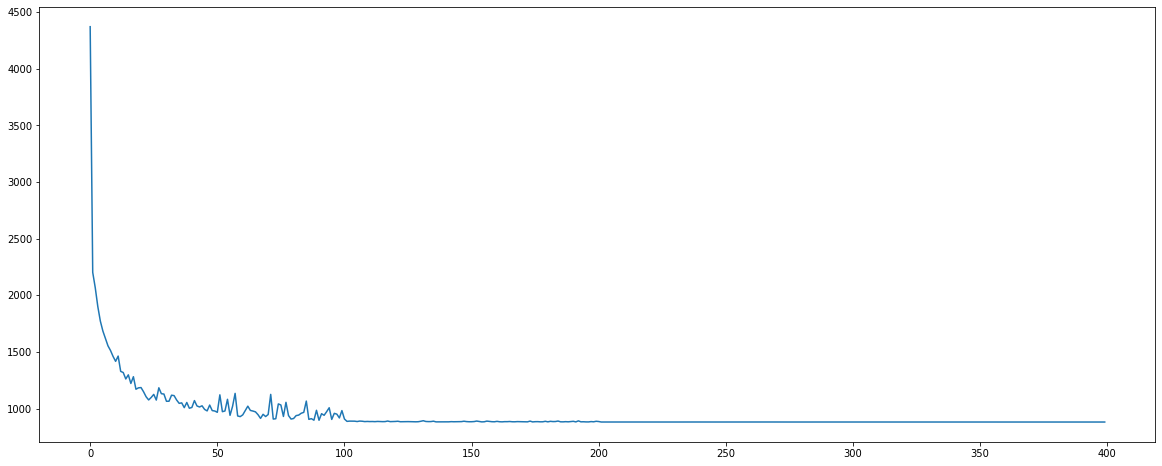

Fold: 9, epoch: 19950, current loss: 880.6274
Fold # 9 Evaluation results:
mse: 3611.2044, rmse: 60.0933, mae: 60.0933, r_squared: 60.0933.
10 fold results:


,fold,mse,rmse,mae,r_squared
0,0,4059.507176,63.714262,34.300744,0.432008
1,1,110103.658444,331.818713,80.515705,-221.910233
2,2,4987.252919,70.620485,36.818258,0.178448
3,3,1390.586853,37.290573,27.538641,-0.815726
4,4,24114.859463,155.289599,49.977647,-21.217698
5,5,6835.217328,82.675373,44.959411,-4.455545
6,6,2484.824721,49.848016,35.672845,0.177432
7,7,5013.012964,70.802634,39.123425,0.087296
8,8,17115.607578,130.826632,53.416233,-1.658382
9,9,3611.204368,60.093297,32.242146,-9.240084


In [16]:
from sklearn.model_selection import KFold
from IPython.display import clear_output
import sklearn.metrics as metrics


fold_k = 10
BATCH_SIZE = 8
epoch_cnt = 20000

input_features = preprocessing.StandardScaler().fit_transform(features_df)


feature_dataset = FeatureDataset(features_np=input_features, labels_np=y_label)
train_dataloader = DataLoader(feature_dataset, batch_size=BATCH_SIZE, shuffle=True)

k_fold_spliter = KFold(n_splits=fold_k, random_state=None, shuffle=True)


cost = torch.nn.MSELoss(reduction='mean')

fig, ax = plt.subplots(figsize=(5, 5))

def draw_loss(losses):
    clear_output()
    print(step, np.mean(batch_loss[-1]))
    plt.plot(losses)
    plt.show()
    

def train_a_model(net, train_dataloader, epoch_cnt = 10, fold=0):
    step = 0 
    losses = []

    

    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5000, 10000, 15000],gamma = 0.2)

    # print(f"Processing {fold} fold.")
    
    for epoch in range(epoch_cnt):

        batch_losses = []
        for x, y in train_dataloader:  # each batch



            x = torch.tensor(x, requires_grad = True).float().to('cuda')
            y = torch.tensor(y, requires_grad = True).float().to('cuda')

             
            # print(y)
            prediction = net(x)
            # print(prediction)

           
            loss = cost(prediction, y)
            
            optimizer.zero_grad()
            
            loss.backward(retain_graph=True)
            # loss.backward()
            
            optimizer.step()

            batch_losses.append(loss.cpu().data.numpy())

            step += 1

        scheduler.step()
        
        if epoch % 50 == 0:
            losses.append(np.mean(batch_losses))
            
            clear_output(wait=True)
            fig = plt.figure(figsize=(20, 8))
            plt.plot(losses)
            plt.show()
            loss_t = np.mean(batch_losses)
            print(f'Fold: {fold}, epoch: {epoch}, current loss: {loss_t:.4f}'  )
        

    return net

    

def eval_model(trained_net, X_test, y_true):
    trained_net.eval().to('cuda')
    y_predict = trained_net(torch.tensor(X_test).float().to('cuda')).cpu().data.numpy()

    mse = metrics.mean_squared_error(y_true, y_predict)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_predict))
    mae = metrics.mean_absolute_error(y_true, y_predict)
    r_squared = metrics.r2_score(y_true, y_predict)

    return y_predict, mse, rmse, mae, r_squared      

# Cross validation
results_df = pd.DataFrame(columns=['fold', 'mse', 'rmse', 'mae', 'r_squared'])
for  idx, (train_index, test_index) in enumerate(k_fold_spliter.split(input_features)):

    my_nn = torch.nn.Sequential(    
    torch.nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),    
    torch.nn.ReLU(),    
    torch.nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE),
    ).to('cuda') 
     

    df_row_cnt = len(results_df)
    print(f"Processing {idx} fold.")
    X_train, X_test = input_features[train_index], input_features[test_index]
    y_train, y_test = y_label[train_index], y_label[test_index]

    print(len(X_train))
    feature_dataset = FeatureDataset(features_np=X_train, labels_np=y_train)

    train_dataloader = DataLoader(feature_dataset, batch_size=BATCH_SIZE, shuffle=False)

    trained_net = train_a_model(my_nn, train_dataloader, epoch_cnt = epoch_cnt, fold=idx)

    torch.save(trained_net, f'trained_model_{idx}.pth')

    y_predict, mse, rmse, mae, r_squared = eval_model(trained_net, X_test, y_test)
    # results_df.iloc[df_row_cnt, '']
    results_df.loc[df_row_cnt] = [idx, mse, rmse, mae, r_squared]
    

    print(f"Fold # {idx} Evaluation results:")
    print(f'mse: {mse:.4f}, rmse: {rmse:.4f}, mae: {mae:.4f}, r_squared: {r_squared:.4f}.' )




results_df['fold'] = results_df['fold'].astype(int)
results_df.to_csv('10_fold_results.csv')
print("10 fold results:")

results_df



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Evaluate the best model


The best model comes from fold # 3. The errors between its prediction and the y-exp are:
mse: 937.4873, rmse: 30.6184, mae: 9.7966, r_squared: 0.7166.

The errors between theorematical prediction and the y-exp are:
mse: 2213.2770, rmse: 47.0455, mae: 17.9104, r_squared: 0.3310.

R squared: 0.7195021580801667
reg.coef_: [[0.76329031]]


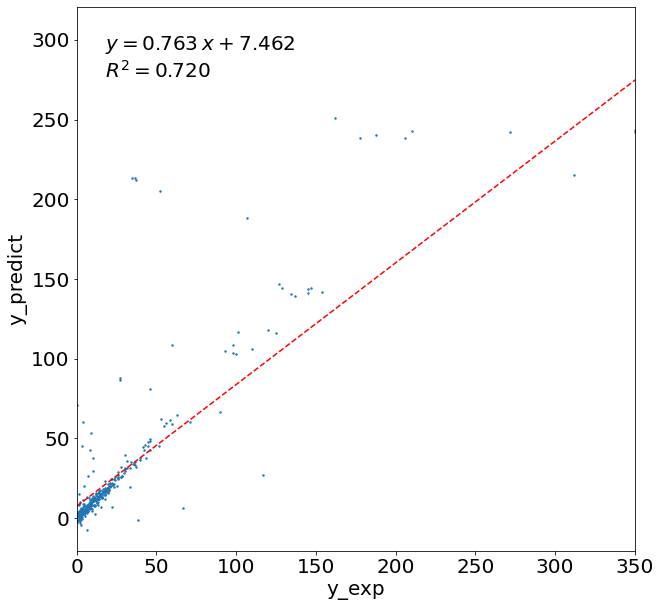

In [34]:
best_model_fold_id = np.argmin(results_df['mae'])

best_model = torch.load(f'trained_model_{best_model_fold_id}.pth')

y_predict, mse, rmse, mae, r_squared = eval_model(best_model, input_features, y_label)

print()
print(f'The best model comes from fold # {best_model_fold_id}. The errors between its prediction and the y-exp are:')
print(f'mse: {mse:.4f}, rmse: {rmse:.4f}, mae: {mae:.4f}, r_squared: {r_squared:.4f}.' )

# evaluate the theoretical prediction and experimental observation
mse = metrics.mean_squared_error(y_label, y_theory)
rmse = np.sqrt(metrics.mean_squared_error(y_label, y_theory))
mae = metrics.mean_absolute_error(y_label, y_theory)
r_squared = metrics.r2_score(y_label, y_theory)

print()
print(f'The errors between theoretical prediction and the y-exp are:')
print(f'mse: {mse:.4f}, rmse: {rmse:.4f}, mae: {mae:.4f}, r_squared: {r_squared:.4f}.' )
print()


def draw_r2_squared(ax2, x_true, y_observed):
    x_true = np.array(x_true).reshape((-1, 1))
    y_observed = np.array(y_observed).reshape((-1, 1))
    reg = LR().fit(x_true, y_observed)
    z = np.polyfit(x_true.ravel(), y_observed.ravel(), 1)
    p = np.poly1d(z)
    y_pred = p(x_true)
    R_squared = r2_score(y_observed, y_pred)
    # print()
    print("R squared:", R_squared)
    print("reg.coef_:", reg.coef_)
    text = f"$y={z[0]:0.3f}\:x{z[1]:+0.3f}$\n$R^2 = {R_squared:0.3f}$"
    ax2.scatter(x=x_true, y=y_observed, s=2)
    ax2.text(0.05, 0.95, text, 
               transform=plt.gca().transAxes,
               fontsize=20,
               verticalalignment='top')
    
    # draw trend line
    line_ends = [min(x_true), max(x_true)]
    end_preds = p(line_ends)
    ax2.plot(line_ends, end_preds, 'r--')


# plt.scatter(y_theory, y_predict)
fig = plt.subplots(figsize=(10, 10))
plt.axis('equal')
plt.ylim([0, 300])
plt.xlim([0, 350])
plt.xlabel("y_exp")
plt.ylabel("y_predict")
font = {'size': 20}
plt.rc('font', **font)
draw_r2_squared(plt.gca(), y_label, y_predict)

# Problem 1 validation

In [24]:
from sklearn import metrics
import numpy as np
 

classes = ['politics', 'business', 'tech', 'entertainment', 'sport']

y_true = [0] * 141 + [1] * 167 + [2] * 133 + [3] * 128 + [4] * 166


# row: actual, col: predict
confusion_matrix = np.array([[140, 1, 0, 0, 0],
                             [4, 160, 2, 0, 1],
                             [1, 3, 128, 0, 1],
                             [0, 0, 1, 127, 0],
                             [0, 1, 0, 0, 165],])

row_cnt, col_cnt = confusion_matrix.shape
y_true = []
y_pred = []
for row in range(row_cnt):
    y_true += [row] *  confusion_matrix[row, :].sum()
    for col in range(col_cnt):
        y_pred += [col] *  confusion_matrix[row, col] 

print("Confusion matix:")
print(metrics.confusion_matrix(y_true, y_pred))

print(metrics.classification_report(y_true, y_pred, digits=4))


Confusion matix:
[[140   1   0   0   0]
 [  4 160   2   0   1]
 [  1   3 128   0   1]
 [  0   0   1 127   0]
 [  0   1   0   0 165]]
              precision    recall  f1-score   support

           0     0.9655    0.9929    0.9790       141
           1     0.9697    0.9581    0.9639       167
           2     0.9771    0.9624    0.9697       133
           3     1.0000    0.9922    0.9961       128
           4     0.9880    0.9940    0.9910       166

    accuracy                         0.9796       735
   macro avg     0.9801    0.9799    0.9799       735
weighted avg     0.9797    0.9796    0.9796       735

